In [1]:
from IPython.display import Markdown as md

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import LSTM, Dense, Input, TimeDistributed, Concatenate, Lambda, Bidirectional, Dropout, RNN
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, SGD

import spektral
from spektral.layers import GraphConv, GraphAttention, GlobalAttentionPool

import seaborn as sns
import numpy as np
import pandas as pd

from data_preparation import *
from visualization import *
from custom_layers.subgraphing import Subgraphing
from custom_layers.custom_lstm_cell import CustomLSTMCell
from custom_layers.graph_reduce_cell import GraphReduceCell
from submissions.submit import *

import time

In [2]:
STACKED_FEATURES_SIZE = 14
EDGES_FEATURES_MATRIX_DEPTH = 3
NEIGHBOURHOOD_SIZE = 20
BATCH_SIZE = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [3]:
# LOADING DATASETS FROM DISK (CREATE THEM IF THEY DON'T EXIST)
train_valid_ds, public_test_ds, private_test_ds = load_base_datasets() 

In [4]:
# LOADING SUBGRAPHED DATASETS FROM DISK (CREATE_THEM IF THEY DON'T EXIST)
subgraphed_train_valid_ds, subgraphed_public_test_ds, subgraphed_private_test_ds = load_subgraphed_datasets(neighbourhood_size=NEIGHBOURHOOD_SIZE) 
subgraphed_train_ds, subgraphed_valid_ds = split_into_train_and_valid(subgraphed_train_valid_ds, 0.3)

In [5]:
inspect_dataset_columns(subgraphed_train_ds)

FEATURES:


,feature_name,tensor_shape
0,sequence,"(68, 4)"
1,structure,"(68, 3)"
2,predicted_loop_type,"(68, 7)"
3,adjacency_matrix,"(68, 20, 20)"
4,edges_features_matrix,"(68, 20, 20, 3)"
5,seq_scored,()
6,stacked_base_features,"(68, 20, 14)"



LABELS:


,label_name,tensor_shape
0,stacked_scored_labels,"(68, 3)"


dataset cardinality: -2


In [6]:
subgraphed_train_ds = subgraphed_train_ds.prefetch(AUTOTUNE).cache().batch(BATCH_SIZE)
subgraphed_valid_ds = subgraphed_valid_ds.prefetch(AUTOTUNE).cache().batch(BATCH_SIZE)
subgraphed_public_test_ds = subgraphed_public_test_ds.prefetch(AUTOTUNE).cache().batch(BATCH_SIZE)
subgraphed_private_test_ds = subgraphed_private_test_ds.prefetch(AUTOTUNE).cache().batch(BATCH_SIZE)

In [7]:
def mcrmse(y_true, y_pred):
    rmse = tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred), axis=1))
    return tf.reduce_mean(rmse, axis=1)

In [8]:
# MODEL FOR SUBGRAPHED INPUTS
base_inputs = Input(shape = (None, NEIGHBOURHOOD_SIZE, STACKED_FEATURES_SIZE), name='stacked_base_features')
adjacency_matrix_inputs = Input(shape=(None, NEIGHBOURHOOD_SIZE, NEIGHBOURHOOD_SIZE), name='adjacency_matrix')
edges_features_matrix_inputs = Input(shape=(None, NEIGHBOURHOOD_SIZE, NEIGHBOURHOOD_SIZE, EDGES_FEATURES_MATRIX_DEPTH), name='edges_features_matrix')

inputs = (base_inputs, adjacency_matrix_inputs, edges_features_matrix_inputs)

x = RNN(GraphReduceCell(64), return_sequences=True)(inputs)

x = Bidirectional(LSTM(128, return_sequences=True))(x)

reactivity_pred = TimeDistributed(Dense(1), name='reactivity')(x)
deg_Mg_pH10_pred = TimeDistributed(Dense(1), name='deg_Mg_pH10')(x)
deg_Mg_50C_pred = TimeDistributed(Dense(1), name='deg_Mg_50C')(x)

scored_outputs = [reactivity_pred, deg_Mg_pH10_pred, deg_Mg_50C_pred]
stacked_scored_outputs = Concatenate(axis=2, name='stacked_outputs')(scored_outputs)
outputs = {'stacked_scored_labels': stacked_scored_outputs}

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss=mcrmse)

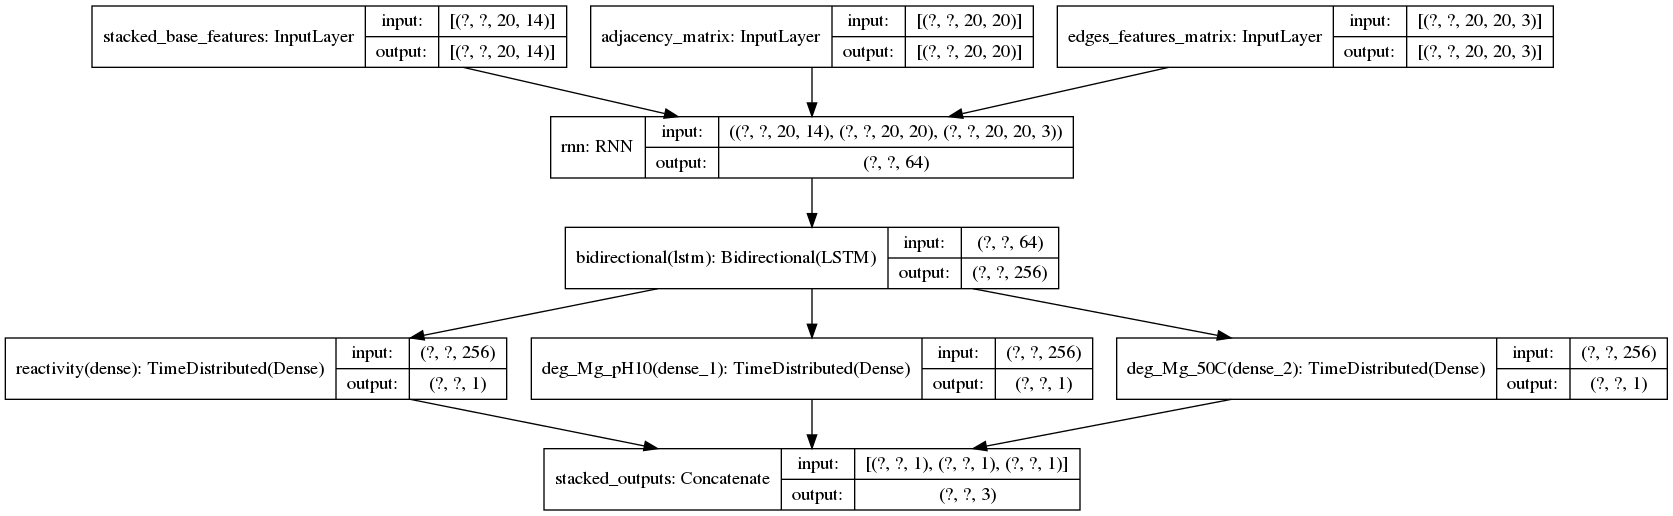

In [9]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [10]:
model.fit(subgraphed_train_ds, validation_data=subgraphed_valid_ds, epochs=10)

Epoch 1/10


/home/jan/.local/share/virtualenvs/covid-EPTM6kfD/lib/python3.7/site-packages/tensorflow/python/keras/engine/functional.py:543: UserWarning: Input dict contained keys ['sequence', 'structure', 'predicted_loop_type', 'seq_scored'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


53/53 [==============================] - 9s 179ms/step - loss: 0.5585 - val_loss: 0.5445
Epoch 2/10
53/53 [==============================] - 8s 159ms/step - loss: 0.5308 - val_loss: 0.5363
Epoch 3/10
53/53 [==============================] - 8s 156ms/step - loss: 0.5219 - val_loss: 0.5283
Epoch 4/10
53/53 [==============================] - 8s 158ms/step - loss: 0.5136 - val_loss: 0.5203
Epoch 5/10
53/53 [==============================] - 8s 157ms/step - loss: 0.5087 - val_loss: 0.5138
Epoch 6/10
53/53 [==============================] - 8s 158ms/step - loss: 0.5037 - val_loss: 0.5115
Epoch 7/10
53/53 [==============================] - 8s 157ms/step - loss: 0.4999 - val_loss: 0.5065
Epoch 8/10
53/53 [==============================] - 8s 158ms/step - loss: 0.4969 - val_loss: 0.5034
Epoch 9/10
53/53 [==============================] - 9s 161ms/step - loss: 0.4924 - val_loss: 0.4997
Epoch 10/10
53/53 [==============================] - 8s 156ms/step - loss: 0.4883 - val_loss: 0.4963


In [12]:
model.evaluate(subgraphed_valid_ds)

23/23 [==============================] - 1s 38ms/step - loss: 0.4963


0.496308296918869

In [13]:
model.save('./models/example_model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./models/example_model/assets


In [14]:
loaded_model = tf.keras.models.load_model('./models/example_model', custom_objects = {'mcrmse': mcrmse, 'GraphReduceCell': GraphReduceCell})

In [15]:
loaded_model.evaluate(subgraphed_valid_ds)

23/23 [==============================] - 1s 39ms/step - loss: 0.4963


0.496308296918869